# 3.1. Tensorflow Mutlivariate exploration

## I - Setup

In [50]:
# Import of librairies
import tensorflow as tf
from tensorflow import keras
import mysql.connector as mariadb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import datetime as dt

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [51]:
class sql_query:
    def __init__(self, credentials_path):
        self.db_credentials = pd.read_csv(credentials_path, index_col="Field")
      
    
    def __call__(self, query):
        
        mariadb_connection = mariadb.connect(
            user=self.db_credentials.loc["user"][0],
            password=self.db_credentials.loc["password"][0],
            host=self.db_credentials.loc["host"][0],
            port=3306,
            db = "db_velib")
        
        self.cursor = mariadb_connection.cursor()
    
        cursor = self.cursor
        cursor.execute(query)
        field_names = [i[0] for i in cursor.description]
        df = pd.DataFrame(cursor, columns=field_names)
        return df

## II. Adaptation pipeline

In [52]:
station_id = 9034
day_of_testing = '2020-05-11'

In [53]:
request = sql_query("../../aws_mariadb_crendentials.csv")

In [54]:
# Taking data from  station 9034 - Madeleine
query = """
SELECT * FROM velib_realtime
WHERE station_id = {}
AND date_of_update > DATE('2020-05-05')
AND date_of_update <= DATE_ADD(DATE('{}'), INTERVAL 1 DAY)
ORDER BY date_of_update ASC
""".format(station_id, day_of_testing)

df = request(query)
df.index = df['date_of_update']

In [55]:
df.head()

,station_id,operational_station,nb_free_docks,nb_total_free_bikes,nb_free_mechanical_bikes,nb_free_electrical_bikes,payment_totem,bike_return_possible,data_actualisation,date_of_update
date_of_update,,,,,,,,,,
2020-05-05 00:01:00,9034,OUI,20,2,1,1,OUI,OUI,2020-05-04 23:26:49,2020-05-05 00:01:00
2020-05-05 00:02:00,9034,OUI,20,2,1,1,OUI,OUI,2020-05-04 23:26:49,2020-05-05 00:02:00
2020-05-05 00:03:00,9034,OUI,20,2,1,1,OUI,OUI,2020-05-04 23:26:49,2020-05-05 00:03:00
2020-05-05 00:04:00,9034,OUI,20,2,1,1,OUI,OUI,2020-05-04 23:26:49,2020-05-05 00:04:00
2020-05-05 00:05:00,9034,OUI,20,2,1,1,OUI,OUI,2020-05-04 23:26:49,2020-05-05 00:05:00


## A - Multilabel data exploration and cleaning

In [56]:
print(list(df.columns))

['station_id', 'operational_station', 'nb_free_docks', 'nb_total_free_bikes', 'nb_free_mechanical_bikes', 'nb_free_electrical_bikes', 'payment_totem', 'bike_return_possible', 'data_actualisation', 'date_of_update']


### Labels to remove:
- station_id: the id is unique by each station
- data_actualisation: not working properly and no interesting information
- date_of_update: already in the index
- nb_free_mechanical_bikes / nb_free_electrical_bikes : it could be interesting to keep becvause it shows a small subtility, but for the moment it only makes the data more complex
- payment_totem: we don't need it to know availiability
- station_id: the id is unique by each station

### Labels to keep:

- nb_total_free_bikes: secondary indicator 

### Labels to use differently:
- operational_station: if no, no prediction can be done in finale version
- bike_return_possible: if no, we cannot return to the station, so it is useless!


### Target :
- nb_free_docks

### Data addition :
- day of the week


## Other idea:
Other version not for one station but for the whole database with station id in order the make calculation on whole data and link it with distance

In [57]:
# Selecting only interesting columns

df = df[['nb_total_free_bikes','nb_free_docks']]
df.head()

,nb_total_free_bikes,nb_free_docks
date_of_update,,
2020-05-05 00:01:00,2,20
2020-05-05 00:02:00,2,20
2020-05-05 00:03:00,2,20
2020-05-05 00:04:00,2,20
2020-05-05 00:05:00,2,20


In [58]:
# Adding weekday

df['weekday'] = df.index.weekday
df.weekday = df.weekday.apply(lambda x: str(x)) # For later use in pre-processing, weekday have to be string
df = df[['weekday','nb_total_free_bikes','nb_free_docks']] # putting target at the end of the dataset
df.head()

,weekday,nb_total_free_bikes,nb_free_docks
date_of_update,,,
2020-05-05 00:01:00,1,2,20
2020-05-05 00:02:00,1,2,20
2020-05-05 00:03:00,1,2,20
2020-05-05 00:04:00,1,2,20
2020-05-05 00:05:00,1,2,20


# A Pré-processing

In [59]:
# Setting the train_split value for later use (around 70%)
TRAIN_SPLIT = round(df.shape[0]*0.9)
tf.random.set_seed(13)
past_history = 180
future_target = 30
STEP = 1
BATCH_SIZE = 32
BUFFER_SIZE = 10000

In [60]:
# Declaration fo target and features_list

features_list = df.columns

X = df.loc[:, features_list]


# Distinction of categorical features
# (string values, columns index for numpy use)

categorical_features_str = (X.select_dtypes(include=['object']).columns)
categorical_features = [X.columns.get_loc(i) for i in categorical_features_str]
print('categorical columns:',categorical_features)

# Distinction of numeric features 

numeric_features_str = X.columns.drop(categorical_features_str)
numeric_features = [X.columns.get_loc(i) for i in numeric_features_str]

print('numeric columns:',numeric_features)

# Division of dataset Train set & Test set 

X_train  = X[:TRAIN_SPLIT]
X_val  = X[TRAIN_SPLIT:]

# Convertion of pandas DataFrames to numpy arrays before using scikit-learn

X_train = X_train.values
X_val = X_val.values

# Declaration of the categorical and numeric transfomers

categorical_transformer = OneHotEncoder(drop='first')
numeric_transformer = StandardScaler()

# Declaration of the feature encoder

feature_encoder = ColumnTransformer(
transformers=[
    ('cat', categorical_transformer, categorical_features),
    ('num', numeric_transformer, numeric_features)
    
]
)

# Fit of the encoder on X_train and transform of X_train

# Fit on X

feature_encoder.fit(X_train)

print('Shape of X_train before feature encoder:', X_train.shape)
X_train = feature_encoder.transform(X_train)
print('Shape of X_train after feature encoder:', X_train.shape)

# Transformation of X_test
X_val = feature_encoder.transform(X_val)
print('Shape of X_val  feature encoder:', X_val.shape)

# Concatenation for full Dataset

X = np.concatenate((X_train, X_val), axis=0)
print('Shape of X after feature encoder:', X.shape)

categorical columns: [0]
numeric columns: [1, 2]
Shape of X_train before feature encoder: (9062, 3)
Shape of X_train after feature encoder: (9062, 8)
Shape of X_val  feature encoder: (1007, 8)
Shape of X after feature encoder: (10069, 8)


In [61]:
# Transforming the input data in the proper format 

def data_preparation(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

x_train, y_train = data_preparation(X, X[:,1], 0, TRAIN_SPLIT,
                                           past_history,
                                           future_target, STEP)
x_val, y_val = data_preparation(X, X[:,1], TRAIN_SPLIT, None,
                                       past_history,
                                       future_target, STEP)

In [62]:
# StandardScaler transformation of the dataset


# Creating proper format data

x_train, y_train = data_preparation(X, X[:,1], 0, TRAIN_SPLIT,
                                           past_history,
                                           future_target, STEP)
x_val, y_val = data_preparation(X, X[:,1], TRAIN_SPLIT, None,
                                       past_history,
                                       future_target, STEP)

# Creating format for NN intput

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2])
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], x_val.shape[2])

# Creating batches for tensorflow use

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data = val_data.batch(BATCH_SIZE).repeat()

print('shape of x_train:', x_train.shape)
print('shape of y_train:', y_train.shape)
print('shape of x_val,', x_val.shape)
print('shape of y_val:', y_val.shape)

shape of x_train: (8882, 180, 8)
shape of y_train: (8882, 30)
shape of x_val, (797, 180, 8)
shape of y_val: (797, 30)


In [80]:
X[0]

array([ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -1.00763408,  1.00763408])

In [63]:
for x, y in train_data.take(1):
    print ('Shape of input train data')
    print (x.shape)
    print ('\n Shape of test train data')
    print (y.shape)   
    print()
    
for x, y in val_data.take(1):
    print ('Shape of input val data')
    print (x.shape)
    print ('\n Shape of test val data')
    print (y.shape)    

Shape of input train data
(32, 180, 8)

 Shape of test train data
(32, 30)

Shape of input val data
(32, 180, 8)

 Shape of test val data
(32, 30)


# Modeling

multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(32, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(30))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [64]:
multivariate_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(BATCH_SIZE, return_sequences=True,input_shape=x_train.shape[-2:]),
    tf.keras.layers.LSTM(8, activation='relu'),
    tf.keras.layers.Dense(future_target)
])

multivariate_lstm_model.compile(optimizer='adam', loss='mae')

multivariate_lstm_model.summary()

print()

for x, y in train_data.take(1):
    print ('Shape of input train data')
    print (x_train.shape)
    print ('\n Shape of test train data')
    print (y_train.shape)   
    print ('\n Shape of test train data')
    print (multivariate_lstm_model.predict(x).shape)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 180, 32)           5248      
_________________________________________________________________
lstm_3 (LSTM)                (None, 8)                 1312      
_________________________________________________________________
dense_1 (Dense)              (None, 30)                270       
Total params: 6,830
Trainable params: 6,830
Non-trainable params: 0
_________________________________________________________________

Shape of input train data
(8882, 180, 8)

 Shape of test train data
(8882, 30)

 Shape of test train data
(32, 30)


multi_step_model.summary()

EPOCHS = 1
EVALUATION_INTERVAL = 200

multi_step_model = multi_step_model.fit(train_data, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data,
                                            validation_steps=2)

In [71]:
EPOCHS =3
EVALUATION_INTERVAL = 200

multivariate_lstm_model_history = multivariate_lstm_model.fit(train_data, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data,
                                            validation_steps=200)


Train for 200 steps, validate for 200 steps
Epoch 1/3
200/200 [==============================] - 29s 146ms/step - loss: 0.0059 - val_loss: 0.0477
Epoch 2/3
200/200 [==============================] - 28s 142ms/step - loss: 0.0060 - val_loss: 0.0459
Epoch 3/3
200/200 [==============================] - 28s 142ms/step - loss: 0.0064 - val_loss: 0.0496


# C - Visualization

In [72]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

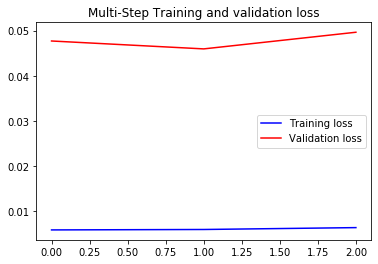

In [73]:
plot_train_history(multivariate_lstm_model_history, 'Multi-Step Training and validation loss')

In [74]:
def create_time_steps(length):
    return list(range(-length, 0))

In [75]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(15, 5))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    plt.plot(num_in, feature_encoder.transformers_[1][1].inverse_transform(history[:,-2:])[:,-1:], label='History')
    
    temp_true_future = np.concatenate((np.array(true_future).reshape(30,1), np.array(true_future).reshape(30,1)),axis=1)
    plt.plot(np.arange(num_out)/STEP, feature_encoder.transformers_[1][1].inverse_transform(temp_true_future)[:,-1:], 
             label='True Future')
    
    if prediction.any():
        temp_prediction = np.concatenate((np.array(prediction).reshape(30,1), np.array(prediction).reshape(30,1)),axis=1)
        plt.plot(np.arange(num_out)/STEP, feature_encoder.transformers_[1][1].inverse_transform(temp_prediction)[:,-1:], 
               label='Predicted Future')
    plt.legend(loc='upper left')

    
    x1, y1 = [0,0], [0, 25]
    ax = plt.plot(x1, y1, linestyle="dashdot", color="black")
    plt.show()

In [76]:
for x, y in val_data.take(1):
    history = x[0]

In [77]:
df

,weekday,nb_total_free_bikes,nb_free_docks
date_of_update,,,
2020-05-05 00:01:00,1,2,20
2020-05-05 00:02:00,1,2,20
2020-05-05 00:03:00,1,2,20
2020-05-05 00:04:00,1,2,20
2020-05-05 00:05:00,1,2,20
...,...,...,...
2020-05-11 23:56:00,0,0,22
2020-05-11 23:57:00,0,0,22
2020-05-11 23:58:00,0,0,22


In [78]:
history[:,-2:]

<tf.Tensor: shape=(180, 2), dtype=float64, numpy=
array([[ 0.40450597, -0.40450597],
       [ 0.40450597, -0.40450597],
       [ 0.40450597, -0.40450597],
       [ 0.40450597, -0.40450597],
       [ 0.40450597, -0.40450597],
       [ 0.40450597, -0.40450597],
       [ 0.40450597, -0.40450597],
       [ 0.40450597, -0.40450597],
       [ 0.40450597, -0.40450597],
       [ 0.40450597, -0.40450597],
       [ 0.40450597, -0.40450597],
       [ 0.40450597, -0.40450597],
       [ 0.40450597, -0.40450597],
       [ 0.40450597, -0.40450597],
       [ 0.40450597, -0.40450597],
       [ 0.40450597, -0.40450597],
       [ 0.40450597, -0.40450597],
       [ 0.40450597, -0.40450597],
       [ 0.40450597, -0.40450597],
       [ 0.40450597, -0.40450597],
       [ 0.40450597, -0.40450597],
       [ 0.40450597, -0.40450597],
       [ 0.40450597, -0.40450597],
       [ 0.40450597, -0.40450597],
       [ 0.40450597, -0.40450597],
       [ 0.40450597, -0.40450597],
       [ 0.40450597, -0.40450597],
     

In [43]:
feature_encoder.transformers_[1][1].inverse_transform(history[:,-2:])[:,-1:]

array([[15.],
       [15.],
       [15.],
       [15.],
       [15.],
       [15.],
       [15.],
       [15.],
       [15.],
       [15.],
       [15.],
       [15.],
       [15.],
       [15.],
       [15.],
       [15.],
       [15.],
       [15.],
       [15.],
       [15.],
       [15.],
       [15.],
       [15.],
       [15.],
       [15.],
       [15.],
       [15.],
       [15.],
       [15.],
       [15.],
       [14.],
       [14.],
       [14.],
       [14.],
       [14.],
       [14.],
       [14.],
       [14.],
       [14.],
       [14.],
       [14.],
       [14.],
       [14.],
       [14.],
       [14.],
       [14.],
       [14.],
       [14.],
       [14.],
       [14.],
       [14.],
       [14.],
       [14.],
       [14.],
       [14.],
       [14.],
       [14.],
       [14.],
       [14.],
       [14.],
       [14.],
       [14.],
       [14.],
       [14.],
       [14.],
       [14.],
       [14.],
       [14.],
       [14.],
       [14.],
       [14.],
      

## III . Results

In [30]:
for x, y in val_data.take(1):
    multi_step_plot(x[0], y[0], multivariate_lstm_model.predict(x)[0])

ValueError: non-broadcastable output operand with shape (180,1) doesn't match the broadcast shape (180,2)

<Figure size 1080x360 with 0 Axes>

## IV. Test with Last Availiable Data

In [ ]:
def last_availiable_data(dataset, past_size, future_size, model):
    last_data = dataset[-past_size-future_size:]
    past = last_data[:past_size]
    future = last_data[-future_size:]
    print(past.shape)
    print(future[:,-1:].shape)
    past = past.reshape(1, past_size, 8)
    future = future[:,-1:].reshape(1, future_size)
    prediction = model.predict(past)
    return past, future, prediction

In [ ]:
history, true_future, prediction = last_availiable_data(df, past_history, future_target, simple_lstm_model)

In [ ]:
feature_encoder?

In [ ]:
prediction_list = np.concatenate((prediction.reshape(-1, 1), prediction.reshape(-1, 1)),axis=1)

In [ ]:
feature_encoder.transformers_[1][1]

In [ ]:
+++++

feature_encoder.transformers_[1][1].inverse_transform(prediction_list)[:,-1]

In [ ]:
multi_step_plot(history[:,-1:], true_future, prediction)

## IV. Prediction future data

In [ ]:
def future_data(dataset, past_size, future_size, model):
    last_data = dataset[-past_size:]
    past = last_data[:past_size]
    past = past.reshape(1, past_size, 1)
    prediction = model.predict(past)
    # Reshaping of output
    past = past.reshape(past_size)
    future = np.zeros(future_size)+past[-1:]
    prediction = prediction.reshape(future_size)
    
    return (past, future, prediction)

In [ ]:
history, future, prediction = future_data(df, past_history, future_target, simple_lstm_model)

In [ ]:
multi_step_plot(history, future, prediction)